In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/preproccessed-dts/amazon_product_reviews/valid.csv
/kaggle/input/preproccessed-dts/amazon_product_reviews/train.csv
/kaggle/input/preproccessed-dts/amazon_product_reviews/test.csv
/kaggle/input/explicit_recommendation_system/keras/default/1/Explicit Surprise - Surprise + CNN/best_model_explicit_finetune.keras
/kaggle/input/explicit_recommendation_system/keras/default/1/Explicit Surprise - Surprise + CNN/frozen_explicit.keras
/kaggle/input/explicit_recommendation_system/keras/default/1/Explicit Surprise - Surprise + CNN/user_embeddings_surprise.npy
/kaggle/input/explicit_recommendation_system/keras/default/1/Explicit Surprise - Surprise + CNN/svd_model.pkl
/kaggle/input/explicit_recommendation_system/keras/default/1/Explicit Surprise - Surprise + CNN/item_embeddings_surprise.npy
/kaggle/input/amazon-product-reviews/Reviews.csv


# I. Load Dataset

In [2]:
import pandas as pd

df = pd.read_csv("/kaggle/input/amazon-product-reviews/Reviews.csv")

In [3]:
print("Data frame : \n", df.head(5))
print("Header: \n",df.columns)

Data frame : 
    Id   ProductId          UserId                      ProfileName  \
0   1  B001E4KFG0  A3SGXH7AUHU8GW                       delmartian   
1   2  B00813GRG4  A1D87F6ZCVE5NK                           dll pa   
2   3  B000LQOCH0   ABXLMWJIXXAIN  Natalia Corres "Natalia Corres"   
3   4  B000UA0QIQ  A395BORC6FGVXV                             Karl   
4   5  B006K2ZZ7K  A1UQRSCLF8GW1T    Michael D. Bigham "M. Wassir"   

   HelpfulnessNumerator  HelpfulnessDenominator  Score        Time  \
0                     1                       1      5  1303862400   
1                     0                       0      1  1346976000   
2                     1                       1      4  1219017600   
3                     3                       3      2  1307923200   
4                     0                       0      5  1350777600   

                 Summary                                               Text  
0  Good Quality Dog Food  I have bought several of the Vitality c

# II. Data Preprocessing

In [4]:
import pandas as pd
import numpy as np

# Lọc dữ liệu cần thiết
df = df[["Id", "ProductId", "UserId", "Score", "Time", "Text"]].dropna()

# Chuyển cột Time sang timestamp
df["timestamp"] = pd.to_datetime(df["Time"], unit='s')
df["timestamp"] = df["timestamp"].astype(np.int64) // 10**9  # Chuyển lại thành int để huấn luyện

# Gán 'user_id' và 'item_id'
df["user_id"] = df["UserId"].astype("category").cat.codes
df["item_id"] = df["ProductId"].astype("category").cat.codes

# Tạo fake 'category_id' và 'parent_category' từ sản phẩm 
df["category_id"] = df["item_id"] % 20  
df["parent_category"] = df["category_id"] // 4 

# Tạo fake giá sản phẩm
np.random.seed(42)
df["price"] = np.random.uniform(5, 100, size=len(df)).round(2)

# Tạo dữ liệu giả cho mỗi user
unique_users = df["user_id"].unique()
user_info = pd.DataFrame({
    "user_id": unique_users,
    "age": np.random.randint(18, 66, size=len(unique_users)),         # Tuổi từ 18 đến 65
    "gender": np.random.randint(0, 2, size=len(unique_users))         # 0: Female, 1: Male
})

# Merge vào df_final
df = df.merge(user_info, on="user_id", how="left")

# Cột rating explicit: Đánh giá theo thang điểm 1-5 (hoặc tương tự)
df["rating"] = df["Score"].astype(np.float32)  # Lấy điểm đánh giá từ cột "Score" để làm rating rõ ràng
df = df[["user_id", "item_id","rating", "category_id", "parent_category", "timestamp", "price", "Text", "age", "gender"]]


In [5]:
print(df.head(10))
print(df.shape)

   user_id  item_id  rating  category_id  parent_category   timestamp  price  \
0   188646    27619     5.0           19                4  1303862400  40.58   
1    25105    72383     1.0            3                0  1346976000  95.32   
2   210482    15267     4.0            7                1  1219017600  74.54   
3   152635    19718     2.0           18                4  1307923200  61.87   
4    57804    69007     5.0            7                1  1350777600  19.82   
5   213950    69007     4.0            7                1  1342051200  19.82   
6    54048    69007     5.0            7                1  1340150400  10.52   
7   172409    69007     5.0            7                1  1336003200  87.29   
8    43414     8132     5.0           12                3  1322006400  62.11   
9    70264    24745     5.0            5                1  1351209600  72.27   

                                                Text  age  gender  
0  I have bought several of the Vitality canned d..

In [6]:
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

# Chuyển đổi kiểu dữ liệu
df["user_id"] = df["user_id"].astype(np.int32)
df["item_id"] = df["item_id"].astype(np.int32)
df["rating"] = df["rating"].astype(np.float32)

# Chuẩn hóa timestamp
scaler = MinMaxScaler()
df["timestamp"] = scaler.fit_transform(df[["timestamp"]])

# Xử lý NaN trong giá sản phẩm bằng median
median_price = df["price"].median()
df["price"] = df["price"].fillna(median_price)

# Áp dụng log transform để giảm độ lệch
df["price"] = np.log1p(df["price"])

# Chuẩn hóa giá trị price
df["price"] = scaler.fit_transform(df[["price"]])

# Chuẩn hóa tuổi
df["age"] = scaler.fit_transform(df[["age"]])

In [7]:
print(df.head(10))
print(df.shape)

   user_id  item_id  rating  category_id  parent_category  timestamp  \
0   188646    27619     5.0           19                4   0.885043   
1    25105    72383     1.0            3                0   0.989721   
2   210482    15267     4.0            7                1   0.679043   
3   152635    19718     2.0           18                4   0.894902   
4    57804    69007     5.0            7                1   0.998951   
5   213950    69007     4.0            7                1   0.977764   
6    54048    69007     5.0            7                1   0.973149   
7   172409    69007     5.0            7                1   0.963080   
8    43414     8132     5.0           12                3   0.929096   
9    70264    24745     5.0            5                1   1.000000   

      price                                               Text       age  \
0  0.685658  I have bought several of the Vitality canned d...  0.340426   
1  0.983196  Product arrived labeled as Jumbo Salted Pe

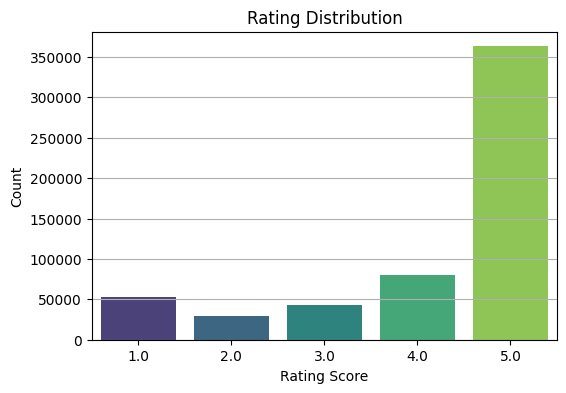

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(6,4))
sns.countplot(x="rating", data=df, palette="viridis")
plt.title("Rating Distribution")
plt.xlabel("Rating Score")
plt.ylabel("Count")
plt.grid(axis='y')
plt.show()

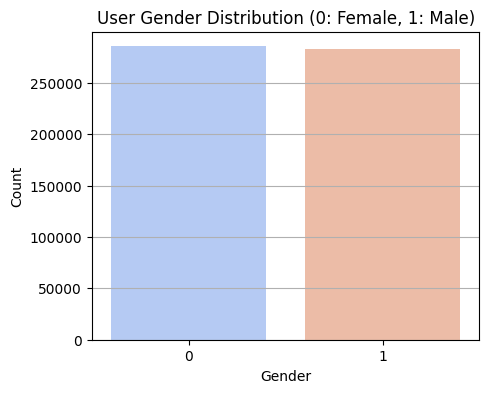

In [9]:
plt.figure(figsize=(5,4))
sns.countplot(x="gender", data=df, palette="coolwarm")
plt.title("User Gender Distribution (0: Female, 1: Male)")
plt.xlabel("Gender")
plt.ylabel("Count")
plt.grid(axis='y')
plt.show()


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


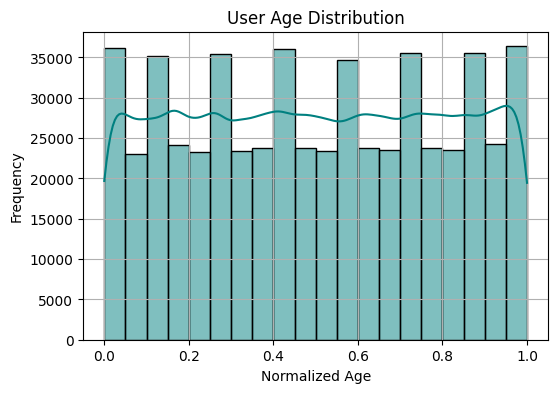

In [10]:
plt.figure(figsize=(6,4))
sns.histplot(df["age"], bins=20, kde=True, color="teal")
plt.title("User Age Distribution")
plt.xlabel("Normalized Age")
plt.ylabel("Frequency")
plt.grid()
plt.show()


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


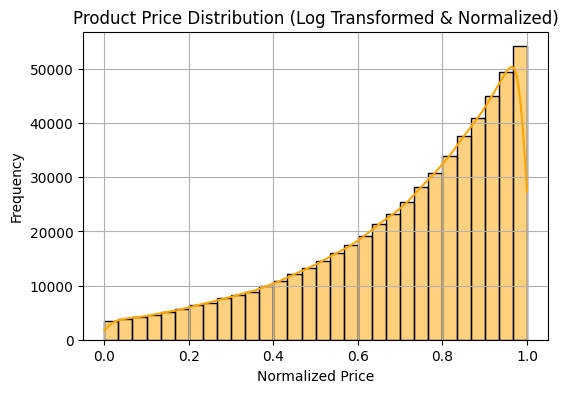

In [11]:
plt.figure(figsize=(6,4))
sns.histplot(df["price"], bins=30, kde=True, color="orange")
plt.title("Product Price Distribution (Log Transformed & Normalized)")
plt.xlabel("Normalized Price")
plt.ylabel("Frequency")
plt.grid()
plt.show()


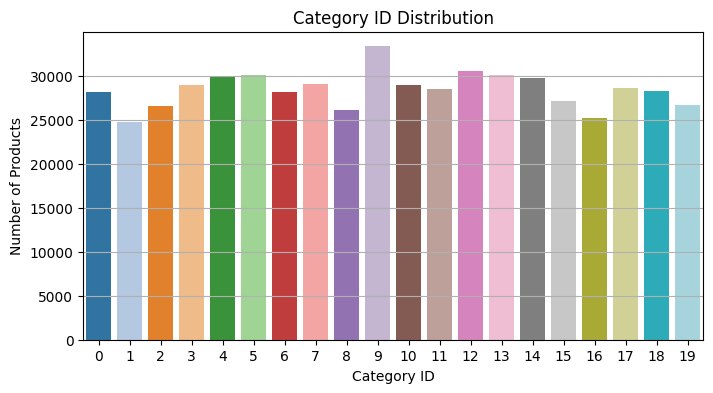

In [12]:
plt.figure(figsize=(8,4))
sns.countplot(x="category_id", data=df, palette="tab20")
plt.title("Category ID Distribution")
plt.xlabel("Category ID")
plt.ylabel("Number of Products")
plt.grid(axis='y')
plt.show()


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


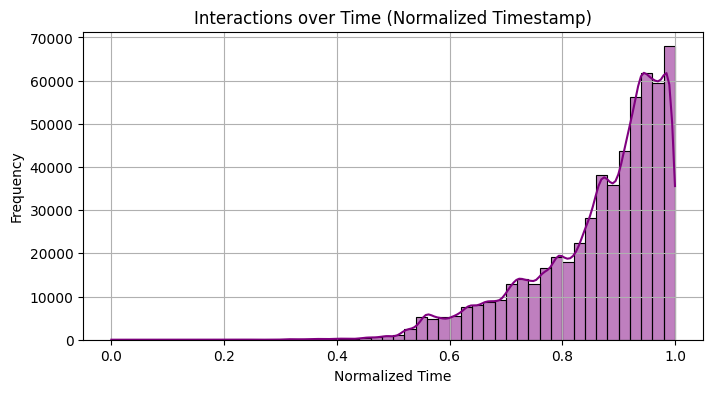

In [13]:
plt.figure(figsize=(8,4))
sns.histplot(df["timestamp"], bins=50, kde=True, color="purple")
plt.title("Interactions over Time (Normalized Timestamp)")
plt.xlabel("Normalized Time")
plt.ylabel("Frequency")
plt.grid()
plt.show()


# III. Split train, valid, test dataset

In [ ]:
from sklearn.model_selection import train_test_split


# 80% train-test
train, test = train_test_split(df, test_size=0.2, random_state=42)

# 70% train và 10% validation
train, valid = train_test_split(train, test_size=0.125, random_state=42)  # 0.125 * 80% = 10%

In [ ]:
train.to_csv("train.csv", index=False)
valid.to_csv("valid.csv", index=False)
test.to_csv("test.csv", index=False)

In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

train = pd.read_csv("/kaggle/input/preproccessed-dts/amazon_product_reviews/train.csv")
valid = pd.read_csv("/kaggle/input/preproccessed-dts/amazon_product_reviews/train.csv")
test = pd.read_csv("/kaggle/input/preproccessed-dts/amazon_product_reviews/test.csv")

In [4]:
from tensorflow.keras.utils import to_categorical

y_train = train["rating"].values
y_valid = valid["rating"].values
y_test = test["rating"].values

print(f"Train Shape: {train.shape}")
print(f"Validation Shape: {valid.shape}")
print(f"Test Shape: {test.shape}")

print ("Example data:")
print (train.head())

2025-05-02 13:35:31.805942: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746192932.099141      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746192932.186095      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Train Shape: (397917, 10)
Validation Shape: (397917, 10)
Test Shape: (113691, 10)
Example data:
   user_id  item_id  rating  category_id  parent_category  timestamp  \
0   130676    42616     5.0           16                4   0.883994   
1   118980     7287     5.0            7                1   0.619257   
2    47772    17878     5.0           18                4   0.864275   
3   119001    36588     5.0            8                2   0.785400   
4   233105    47470     5.0           10                2   0.863436   

      price                                               Text       age  \
0  0.980612  This made my party-throwing so much easier.  O...  0.340426   
1  0.316660  Poland Springs bottled water actually does com...  0.531915   
2  0.855634  My dog gets tired of dry food so quickly we ha...  0.425532   
3  0.169409  Until recently, I was able to purchase Nonni b...  0.148936   
4  0.153315  This is absolutely the best there is!  Prior t...  0.957447   

   gender  
0 

In [5]:
print(train["rating"].value_counts(normalize=True))

rating
5.0    0.638063
4.0    0.142361
1.0    0.092190
3.0    0.074875
2.0    0.052511
Name: proportion, dtype: float64


In [6]:
print(train["rating"].unique())  # Kiểm tra các giá trị trong rating


[5. 4. 3. 2. 1.]


Nhận thấy tập dữ liệu thực tế này mất cân bằng

# IV. Build Surprise model

**Train Surprise model**

In [7]:
!pip install scikit-surprise

In [7]:
import surprise
print(surprise.__version__)

1.1.4


In [8]:
from surprise import SVD, Dataset, Reader, accuracy
# XÂY DỰNG SURPRISE DATASETS 
reader     = Reader(rating_scale=(1, 5))
data_train = Dataset.load_from_df(train[["user_id","item_id","rating"]], reader)
data_valid = Dataset.load_from_df(valid[["user_id","item_id","rating"]], reader)
data_test  = Dataset.load_from_df(test[ ["user_id","item_id","rating"]], reader)

trainset = data_train.build_full_trainset()
validset = data_valid.build_full_trainset().build_testset()
testset  = data_test .build_full_trainset().build_testset()

# # LEARNING CURVE TRÊN VALIDATION
# n_epochs = 100
# for e in range(1, n_epochs+1):
#     model = SVD(n_factors=64, n_epochs=e, reg_all=0.1, random_state=42)
#     model.fit(trainset)
    
#     # Đánh giá RMSE trên validset
#     preds    = model.test(validset)
#     rmse_val = accuracy.rmse(preds, verbose=False)
#     print(f"  Epoch={e:2d} → Validation RMSE: {rmse_val:.4f}")

In [ ]:
# #  HUẤN LUYỆN CUỐI và ĐÁNH GIÁ TRÊN TEST 
# final_model = SVD(n_factors=128, n_epochs=n_epochs, reg_all=0.1, random_state=42)
# final_model.fit(trainset)

In [ ]:
import joblib
# --- 4. LƯU MÔ HÌNH SVD ---
model_filename = 'svd_model.pkl'
joblib.dump(final_model, model_filename)
print(f"Mô hình đã được lưu vào: {model_filename}")

In [10]:
import joblib
# Tải lại mô hình đã lưu
final_model = joblib.load('/kaggle/input/explicit_recommendation_system/keras/default/1/Explicit Surprise - Surprise + CNN/svd_model.pkl')

**Evaluation Surprise Model**

In [11]:
# Đánh giá trên test set
preds_test = final_model.test(testset)
print("  Test RMSE:", accuracy.rmse(preds_test, verbose=False))
print("  Test MAE :", accuracy.mae(preds_test, verbose=False))

  Test RMSE: 1.0288059450509446
  Test MAE : 0.7111821952053239


# V. Build CNN + LightFM Model

**Prepare training data for the model**

In [12]:
user_embeddings = final_model.pu  # user embeddings
item_embeddings = final_model.qi  # item embeddings

print("User embeddings shape:", user_embeddings.shape)
print("Item embeddings shape:", item_embeddings.shape)

User embeddings shape: (199888, 128)
Item embeddings shape: (63800, 128)


In [ ]:
# np.save('user_embeddings_surprise.npy', user_embeddings)
# np.save('item_embeddings_surprise.npy', item_embeddings)

In [13]:
num_users, embedding_dim = user_embeddings.shape
num_products = item_embeddings.shape[0]

print("Number of users = ", num_users)
print("Number of products = ", num_products)
print("Demension embedding = ", embedding_dim)

Number of users =  199888
Number of products =  63800
Demension embedding =  128


In [14]:
# Kiểm tra số lượng danh mục sản phẩm
num_categories = train["category_id"].nunique()
print("Number of categories =", num_categories)

# Kiểm tra số lượng unique parent_category
num_parent_categories = train["parent_category"].nunique()
print("Number of parent categories =", num_parent_categories)

Number of categories = 20
Number of parent categories = 5


**Build&Train Model LightFM + CNN** 

In [ ]:
metadata_config = {
    "user_input": {
        "shape": (1,),
        "dtype": 'int32',
        "embedding": True,
        "dim": num_users,
        "weights": user_embeddings,
    },
    "product_input": {
        "shape": (1,),
        "dtype": 'int32',
        "embedding": True,
        "dim": num_products,
        "weights": item_embeddings,
    },
    "category_input": {
        "shape": (1,),
        "dtype": 'int32',
        "embedding": True,
        "dim": num_categories,
    },
    "parent_category_input": {
        "shape": (1,),
        "dtype": 'int32',
        "embedding": True,
        "dim": num_parent_categories,
    },
    "timestamp_input": {
        "shape": (1,),
        "dtype": 'float32',
        "dense": True,
    },
    "price_input": {
        "shape": (1,),
        "dtype": 'float32',
        "dense": True,
    },
    "age_input": {
        "shape": (1,),
        "dtype": 'float32',
        "dense": True,
    },
    "gender_input": {
        "shape": (1,),
        "dtype": 'float32',
        "dense": True,
    }
}


In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, Embedding, Flatten, Dense, Dropout, Concatenate,
                                     Multiply, BatchNormalization, Reshape, GaussianNoise, Conv1D, GlobalMaxPooling1D)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
import tensorflow as tf

def build_model(trainable_embedding=False):
    inputs = {}
    embeddings = {}
    dense_features = []

    # Build the inputs and embeddings
    for name, cfg in metadata_config.items():
        inp = Input(shape=cfg["shape"], dtype=cfg["dtype"], name=name)
        inputs[name] = inp

        if cfg.get("embedding"):
            emb_weights = [cfg["weights"]] if "weights" in cfg else None
            emb_dim = cfg["weights"].shape[1] if "weights" in cfg else embedding_dim
            emb_layer = Embedding(input_dim=cfg["dim"], output_dim=emb_dim,
                                  weights=emb_weights, trainable=trainable_embedding)(inp)
            emb_layer = GaussianNoise(0.01)(emb_layer)
            emb_layer = Flatten()(emb_layer)
            embeddings[name] = emb_layer
            print(f"Embedding layer for {name} shape: {emb_layer.shape}")
        elif cfg.get("dense"):
            dense = Dense(16, activation='relu')(inp)
            dense = BatchNormalization()(dense)
            dense = Dropout(0.2)(dense)
            dense_features.append(dense)

    # === Convolutional Layers ===
    user_emb = embeddings["user_input"]
    product_emb = embeddings["product_input"]
    
    # Reshape embeddings to apply Conv1D
    user_emb_reshaped = Reshape((-1, 1))(user_emb)  # Reshape to (batch_size, 1, embedding_dim)
    product_emb_reshaped = Reshape((-1, 1))(product_emb)  # Reshape to (batch_size, 1, embedding_dim)
    
    # Apply Conv1D layers
    user_emb_conv = Conv1D(filters=64, kernel_size=3, padding='same', activation='relu')(user_emb_reshaped)
    user_emb_conv = GlobalMaxPooling1D()(user_emb_conv)
    print(f"User convolution output shape: {user_emb_conv.shape}")

    product_emb_conv = Conv1D(filters=64, kernel_size=3, padding='same', activation='relu')(product_emb_reshaped)
    product_emb_conv = GlobalMaxPooling1D()(product_emb_conv)
    print(f"Product convolution output shape: {product_emb_conv.shape}")

    # Element-wise product of user and product embeddings
    user_product_interaction = Multiply()([user_emb, product_emb])

    # === Merge all features ===
    merged = Concatenate()([
        user_emb, 
        product_emb, 
        user_product_interaction,
        embeddings.get("category_input", []),
        embeddings.get("parent_category_input", []),
        *dense_features,
        user_emb_conv,  # Add Convolutional outputs
        product_emb_conv  # Add Convolutional outputs
    ])
    print(f"Merged features shape: {merged.shape}")

    # === Dense Layers ===
    fc1 = Dense(512, activation='relu', kernel_regularizer=l2(1e-4))(merged)
    fc1 = BatchNormalization()(fc1)
    fc1 = Dropout(0.4)(fc1)

    fc2 = Dense(256, activation='relu', kernel_regularizer=l2(1e-4))(fc1)
    fc2 = BatchNormalization()(fc2)
    fc2 = Dropout(0.4)(fc2)

    fc3 = Dense(128, activation='relu', kernel_regularizer=l2(1e-4))(fc2)
    fc3 = BatchNormalization()(fc3)
    fc3 = Dropout(0.3)(fc3)

    fc4 = Dense(64, activation='relu', kernel_regularizer=l2(1e-4))(fc3)
    fc4 = Dropout(0.3)(fc4)

    print("Before output layer:", fc4.shape)

    # Final output layer (linear regression)
    output = Dense(1, activation='linear', name="output")(fc4)

    model = Model(inputs=list(inputs.values()), outputs=output)

    model.compile(optimizer=Adam(learning_rate=1e-3), loss="mse", metrics=["mae"])
    
    return model

# Build the model
model = build_model(trainable_embedding=False)


In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model, show_shapes=True, show_layer_names=True)

In [ ]:
model.summary()

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=20,
    restore_best_weights=True,
    mode='min'
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=15,
    min_lr=1e-6
)

model_checkpoint = ModelCheckpoint(
    filepath='frozen_explicit.keras',      
    monitor='val_loss',
    save_best_only=True,
    mode='min',
    verbose=1
)

callbacks = [early_stopping, reduce_lr, model_checkpoint]


In [18]:
# Prepare data
X_test = [test["user_id"].values, test["item_id"].values, test["category_id"].values,
          test["parent_category"].values, test["timestamp"].values, test["price"].values, test["age"].values, test["gender"].values]
X_valid = [valid["user_id"].values, valid["item_id"].values, valid["category_id"].values,
           valid["parent_category"].values, valid["timestamp"].values, valid["price"].values, valid["age"].values, valid["gender"].values]
X_train = [train["user_id"].values, train["item_id"].values, train["category_id"].values,  train["parent_category"].values, 
           train["timestamp"].values, train["price"].values, train["age"].values, train["gender"].values]

**Train model with freeze embedding**

In [ ]:
model.fit(
    X_train,
    y_train,
    validation_data=(X_valid, y_valid),
    epochs=100,
    batch_size=128,
    shuffle=True,
    callbacks=callbacks
)


In [15]:
from tensorflow.keras.models import load_model

model = load_model('/kaggle/input/explicit_recommendation_system/keras/default/1/Explicit Surprise - Surprise + CNN/frozen_explicit.keras')

2025-05-02 13:39:02.715381: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


**Evaluation**

In [16]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [19]:
test_loss, test_mae = model.evaluate(
   X_test,
    y_test
)
print(f"Test Loss: {test_loss}")
print(f"Test MAE: {test_mae}")


I0000 00:00:1746193164.999930      93 service.cc:148] XLA service 0x78fe980127f0 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1746193165.000728      93 service.cc:156]   StreamExecutor device (0): Host, Default Version


  18/3553 ━━━━━━━━━━━━━━━━━━━━ 22s 6ms/step - loss: 1.5834 - mae: 0.9871 

I0000 00:00:1746193165.736983      93 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


3553/3553 ━━━━━━━━━━━━━━━━━━━━ 23s 6ms/step - loss: 1.6845 - mae: 1.0198
Test Loss: 1.6797152757644653
Test MAE: 1.0187265872955322


In [20]:
predictions = model.predict(X_test)

test_mse = mean_squared_error(y_test, predictions)
test_r2 = r2_score(y_test, predictions)

print(f"Test MSE: {test_mse}")
print(f"Test R²: {test_r2}")

3553/3553 ━━━━━━━━━━━━━━━━━━━━ 22s 6ms/step
Test MSE: 1.6583986846561956
Test R²: 0.02605055405433432


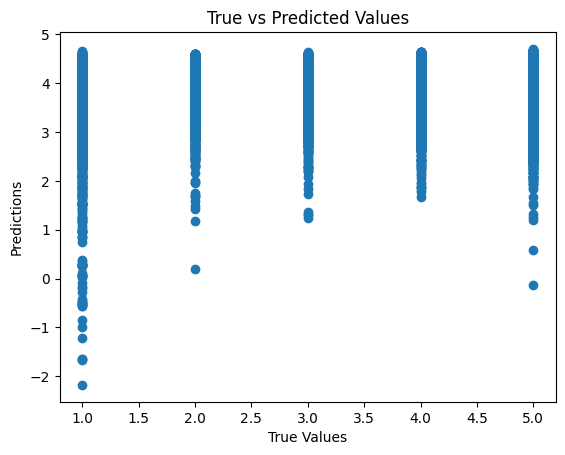

In [21]:
# Plot True vs Predicted values
plt.scatter(y_test, predictions)
plt.xlabel("True Values")
plt.ylabel("Predictions")
plt.title("True vs Predicted Values")
plt.show()

**Fine-tuning model with retraining of embedding layers**

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

early_stopping_ft = EarlyStopping(
    monitor='val_loss',
    patience=10, 
    restore_best_weights=True,
    mode='min'
)

reduce_lr_ft = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=5, 
    min_lr=1e-6,
    verbose=1
)

model_checkpoint_ft = ModelCheckpoint(
    filepath='best_model_explicit_finetune.keras',  
    monitor='val_loss',
    save_best_only=True,
    mode='min',
    verbose=1
)

callbacks_finetune = [early_stopping_ft, reduce_lr_ft, model_checkpoint_ft]


In [ ]:
# Fine-tune embedding
for layer in model.layers:
    if 'user_emb' in layer.name or 'product_emb' in layer.name:
        layer.trainable = True

# Re-compile với learning rate nhỏ hơn
model.compile(optimizer=Adam(learning_rate=1e-4), loss="mse", metrics=["mae"])

# Fine-tuning
model.fit(
   X_train,
    y_train,
    validation_data=(
       X_valid,
        y_valid
    ),
    epochs=50,
    batch_size=128,
    shuffle=True,
    callbacks=callbacks
)


In [22]:
from tensorflow.keras.models import load_model

model = load_model('/kaggle/input/explicit_recommendation_system/keras/default/1/Explicit Surprise - Surprise + CNN/best_model_explicit_finetune.keras')

**Evalution**

In [23]:
test_loss, test_mae = model.evaluate(
   X_test,
    y_test
)
print(f"Test Loss: {test_loss}")
print(f"Test MAE: {test_mae}")


3553/3553 ━━━━━━━━━━━━━━━━━━━━ 23s 6ms/step - loss: 1.6907 - mae: 1.0187
Test Loss: 1.6863762140274048
Test MAE: 1.0176336765289307


In [24]:
predictions = model.predict(X_test)

# Calculate additional evaluation metrics
test_mse = mean_squared_error(y_test, predictions)
test_r2 = r2_score(y_test, predictions)

print(f"Test MSE: {test_mse}")
print(f"Test R²: {test_r2}")

3553/3553 ━━━━━━━━━━━━━━━━━━━━ 24s 7ms/step
Test MSE: 1.6676469772926137
Test R²: 0.020619188501213248


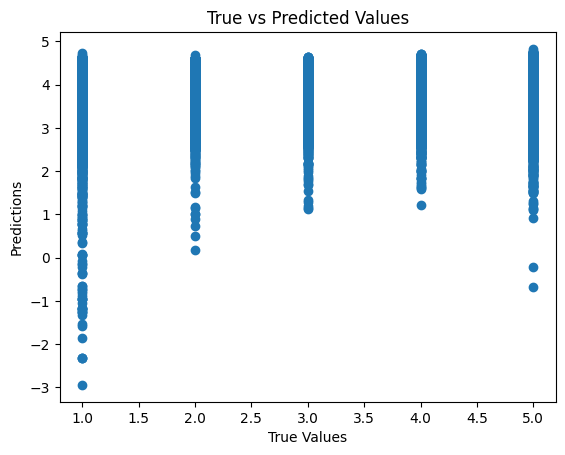

In [25]:
# Plot True vs Predicted values
plt.scatter(y_test, predictions)
plt.xlabel("True Values")
plt.ylabel("Predictions")
plt.title("True vs Predicted Values")
plt.show()

# VI. Evaluation Model

In [26]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [27]:
# Đánh giá mô hình trên các tập dữ liệu
train_loss, train_mae = model.evaluate(X_train, y_train, verbose=0)
val_loss, val_mae = model.evaluate(X_valid, y_valid, verbose=0)
test_loss, test_mae = model.evaluate(X_test, y_test, verbose=0)

print(f"Train Loss: {train_loss:.4f}, MAE: {train_mae:.4f}")
print(f"Validation Loss: {val_loss:.4f}, MAE: {val_mae:.4f}")
print(f"Test Loss: {test_loss:.4f}, MAE: {test_mae:.4f}")


Train Loss: 1.5469, MAE: 0.9768
Validation Loss: 1.5469, MAE: 0.9768
Test Loss: 1.6864, MAE: 1.0176


In [28]:
# Dự đoán trên tập test
y_pred = model.predict(X_test)

# Tính thêm MAE, RMSE, R2 score
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"Test MAE (sklearn): {mae:.4f}")
print(f"Test RMSE: {rmse:.4f}")
print(f"R² Score: {r2:.4f}")


3553/3553 ━━━━━━━━━━━━━━━━━━━━ 22s 6ms/step
Test MAE (sklearn): 1.0176
Test RMSE: 1.2914
R² Score: 0.0206


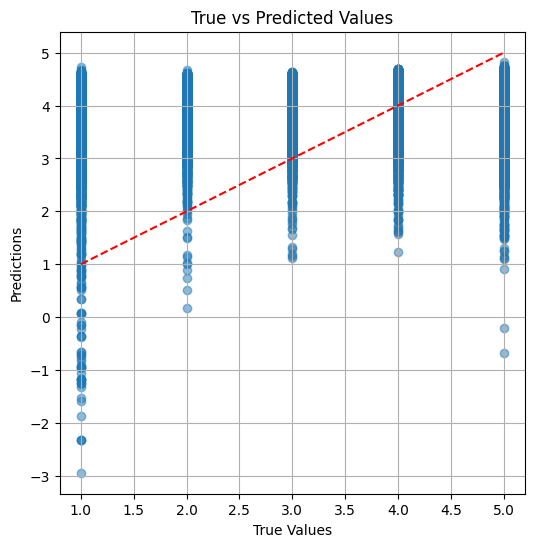

In [29]:
# Biểu đồ True vs Predicted (Scatter plot)
plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')
plt.xlabel("True Values")
plt.ylabel("Predictions")
plt.title("True vs Predicted Values")
plt.grid(True)
plt.show()


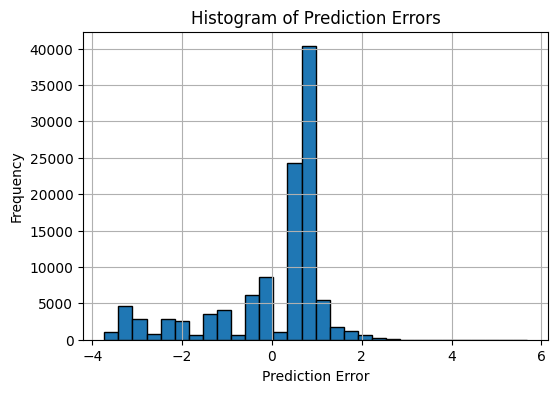

In [30]:
# Histogram lỗi
errors = y_test.flatten() - y_pred.flatten()
plt.figure(figsize=(6, 4))
plt.hist(errors, bins=30, edgecolor='black')
plt.xlabel("Prediction Error")
plt.ylabel("Frequency")
plt.title("Histogram of Prediction Errors")
plt.grid(True)
plt.show()

In [31]:
# In bảng so sánh
comparison_df = pd.DataFrame({
    "Actual": y_test.flatten(),
    "Predicted": y_pred.flatten()
})
print("\nSo sánh giá trị thực tế và dự đoán:")
print(comparison_df.head(10))


So sánh giá trị thực tế và dự đoán:
   Actual  Predicted
0     5.0   4.323226
1     5.0   4.148507
2     3.0   4.350224
3     2.0   4.061066
4     5.0   4.079876
5     4.0   3.868459
6     5.0   4.469020
7     5.0   4.434078
8     4.0   4.287786
9     5.0   4.107991


In [32]:
import numpy as np
import pandas as pd

# Gán ID người dùng cần gợi ý
sample_user = 2134

# Lấy danh sách tất cả sản phẩm
all_items = np.array(range(num_products))

# Lấy thông tin đặc trưng mặc định cho người dùng đó từ test hoặc train (nếu có)
user_info = train[train["user_id"] == sample_user]
if user_info.empty:
    user_info = test[test["user_id"] == sample_user]
    
if user_info.empty:
    raise ValueError("User không tồn tại trong dataset.")

# Lấy các thông tin cố định từ dòng đầu tiên
user_category = user_info.iloc[0]["category_id"]
user_parent_category = user_info.iloc[0]["parent_category"]
user_timestamp = user_info.iloc[0]["timestamp"]
user_price = user_info.iloc[0]["price"]
user_age = user_info.iloc[0]["age"]
user_gender = user_info.iloc[0]["gender"]

# Tạo dữ liệu input cho toàn bộ sản phẩm đối với sample_user
user_input = np.array([sample_user] * num_products)
category_input = np.array([user_category] * num_products)
parent_category_input = np.array([user_parent_category] * num_products)
timestamp_input = np.array([user_timestamp] * num_products)
price_input = np.array([user_price] * num_products)
age_input = np.array([user_age] * num_products)
gender_input = np.array([user_gender] * num_products)
# Tạo input cho mô hình
X_predict = [
    user_input,
    all_items,
    category_input,
    parent_category_input,
    timestamp_input,
    price_input,
    age_input,
    gender_input
]

# Dự đoán điểm đánh giá cho tất cả sản phẩm
predicted_ratings = model.predict(X_predict, batch_size=128, verbose=0)

# Lấy top sản phẩm được dự đoán cao nhất
top_k = 5
top_indices = np.argsort(predicted_ratings.reshape(-1))[::-1][:top_k]
recommended_items = all_items[top_indices]
recommended_scores = predicted_ratings[top_indices].reshape(-1)

# In kết quả
print(f"Top {top_k} sản phẩm được gợi ý cho user {sample_user}:")
for i, (item_id, score) in enumerate(zip(recommended_items, recommended_scores), 1):
    print(f"{i}. Item ID: {item_id} | Predicted Rating: {score:.4f}")

Top 5 sản phẩm được gợi ý cho user 2134:
1. Item ID: 3968 | Predicted Rating: 4.6823
2. Item ID: 44307 | Predicted Rating: 4.6602
3. Item ID: 554 | Predicted Rating: 4.6587
4. Item ID: 8665 | Predicted Rating: 4.6542
5. Item ID: 16005 | Predicted Rating: 4.6536


# [Importance] Cold-start problem

In [33]:
# Danh sách user và item trong tập train
train_users = set(train["user_id"].unique())
train_items = set(train["item_id"].unique())

# Dữ liệu cold-start từ test
cold_start_user_test = test[~test["user_id"].isin(train_users)]
cold_start_item_test = test[~test["item_id"].isin(train_items)]

# Dữ liệu không cold-start từ test
non_cold_start_test = test[test["user_id"].isin(train_users) & test["item_id"].isin(train_items)]


# In thông tin thống kê
print(f"Cold-start user (test): {len(cold_start_user_test)} samples")
print(f"Cold-start item (test): {len(cold_start_item_test)} samples")
print(f"Non Cold-start item (test): {len(non_cold_start_test)} samples")

Cold-start user (test): 40052 samples
Cold-start item (test): 8137 samples
Non Cold-start item (test): 69778 samples


In [34]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

def evaluate_model(model, data, y_true):
    y_pred = model.predict([
        data["user_id"].values,
        data["item_id"].values,
        data["category_id"].values,
        data["parent_category"].values,
        data["timestamp"].values,
        data["price"].values,
        data["age"].values,
        data["gender"].values
    ], batch_size=128, verbose=0)

    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    return rmse, mae


In [35]:
# Cold-start user
rmse_user_test, mae_user_test = evaluate_model(model, cold_start_user_test, cold_start_user_test["rating"].values)

# Cold-start item
rmse_item_test, mae_item_test = evaluate_model(model, cold_start_item_test, cold_start_item_test["rating"].values)

# Non-cold-start
rmse_non_cold, mae_non_cold = evaluate_model(model, non_cold_start_test, non_cold_start_test["rating"].values)

# Kết quả
print("\n Cold-start Evaluation Results:")
print(f"[Cold-start Users] RMSE: {rmse_user_test:.4f}, MAE: {mae_user_test:.4f}")
print(f"[Cold-start Items] RMSE: {rmse_item_test:.4f}, MAE: {mae_item_test:.4f}")
print(f"[Non-Cold-start]   RMSE: {rmse_non_cold:.4f}, MAE: {mae_non_cold:.4f}")



 Cold-start Evaluation Results:
[Cold-start Users] RMSE: 1.3768, MAE: 1.0872
[Cold-start Items] RMSE: 1.3967, MAE: 1.1084
[Non-Cold-start]   RMSE: 1.2383, MAE: 0.9762


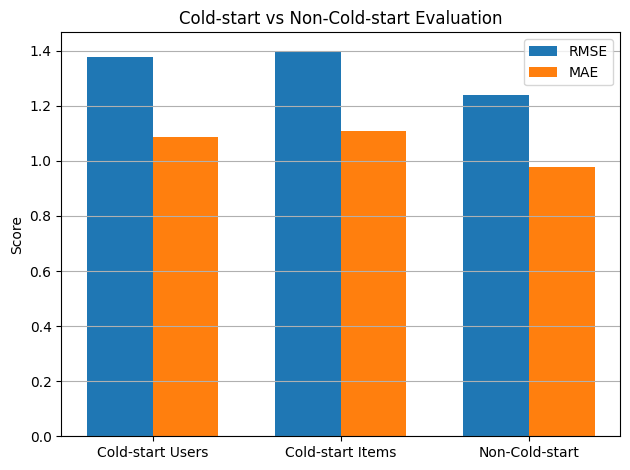

In [36]:
import matplotlib.pyplot as plt

labels = ['Cold-start Users', 'Cold-start Items', 'Non-Cold-start']
rmse_values = [rmse_user_test, rmse_item_test, rmse_non_cold]
mae_values = [mae_user_test, mae_item_test, mae_non_cold]

x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots()
ax.bar(x - width/2, rmse_values, width, label='RMSE')
ax.bar(x + width/2, mae_values, width, label='MAE')

ax.set_ylabel('Score')
ax.set_title('Cold-start vs Non-Cold-start Evaluation')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()
plt.grid(axis='y')
plt.tight_layout()
plt.show()
